Heteroscedastic Implementation of Deep Ensembles

no adversarial Training is used

Most of the code inspired by:
https://github.com/cameronccohen/deep-ensembles/blob/master/Tutorial.ipynb

Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np
import optuna
from optuna.trial import TrialState
import random
import uncertainty_toolbox as uct


# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

import utils.data_prep as data_prep
import utils.metrices as metrices
import utils.NN_model as NN_model

In [8]:
SEED = 42

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

Load, Transform and Split the data

In [2]:
#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1,1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1,1)
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1,1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)
print(y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
torch.Size([31206, 1]) torch.Size([10402, 1]) torch.Size([10403, 1])


Optuna Hyperparameter Search

In [ ]:
def objective(trial):
    
    set_seed(SEED)  # Set the seed for reproducibility
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 5)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 64, 320, step=32)  # number of neurons in each hidden layer
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128]) 
    decay = trial.suggest_float('decay', 0.5, 0.7, step = 0.1)

    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=0,
        loss_type = 'heteroscedastic'
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            
            loss = NN_model.heteroscedastic_loss(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            val_loss = NN_model.heteroscedastic_loss(model, X_val_tensor, y_val_tensor)
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return best_val_loss


In [9]:
print(f"Using device: {device}")

# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed = SEED),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=20,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=200, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-09-18 08:05:41,077] A new study created in memory with name: no-name-5e304789-c118-46fd-accd-ed54bd031da8


Using device: cuda


  0%|          | 0/200 [00:00<?, ?it/s]

Hidden dimensions: [320, 160, 80]
[W 2025-09-18 08:05:45,723] Trial 0 failed with parameters: {'n_layer': 3, 'n_neurons': 320, 'lr': 0.0029106359131330704, 'batch_size': 64, 'decay': 0.5} because of the following error: TypeError("DataLoader.__init__() got an unexpected keyword argument 'random_state'").
Traceback (most recent call last):
  File "c:\Users\test\Masterarbeit\.venv\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\test\AppData\Local\Temp\ipykernel_10756\3344113643.py", line 33, in objective
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, random_state=42)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: DataLoader.__init__() got an unexpected keyword argument 'random_state'
[W 2025-09-18 08:05:45,725] Trial 0 failed with value None.


TypeError: DataLoader.__init__() got an unexpected keyword argument 'random_state'

Create an Ensemble

best Model Architectur implemented:
hidden_dims=[320,224,156]

Best trial:
  Value:  1.4413212537765503
  Params: 
    n_layer: 3
    n_neurons: 320
    lr: 0.0004348009611810878
    batch_size: 64
    decay: 0.7

In [4]:
# number of networks
n = 5
nets_ops = []

for i in range(n):
    net = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[320,224,156], output_dim=1, do_rate=0, loss_type='heteroscedastic')  # Create model instance and move to device
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.0004, weight_decay=0.0001)  # Create optimizer
    nets_ops.append((net, optimizer))
    
print(nets_ops[0])  # Print the first model to check if it was created correctly

(Custom_NN_Model(
  (hidden_layers): Sequential(
    (0): Linear(in_features=37, out_features=320, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=320, out_features=224, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=224, out_features=156, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
  )
  (mean_layer): Linear(in_features=156, out_features=1, bias=True)
  (var_layer): Linear(in_features=156, out_features=1, bias=True)
), AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0004
    maximize: False
    weight_decay: 0.0001
))


Method for Training the Ensembles

In [5]:
def train_model(net, optimizer, X_train, y_train, X_val, y_val, X_test,  batch_size=64, n_epochs=1000, patience=20, device = 'cpu'):
    
    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
        
    # Early Stopping values
    best_val_loss = np.inf
    epochs_no_improve = 0
    loss_history = []
    val_loss_history = []
    net.to(device)  # Move model to device
    for epoch in range(n_epochs):
        net.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            #print(y_batch.shape)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #print(net(X_batch)[0].shape)
            optimizer.zero_grad()
            loss = NN_model.heteroscedastic_loss(net, X_batch, y_batch) # does a forward pass and computes the loss  
           
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        loss_history.append(loss.item())
            
        # calculate validation loss
        net.eval()                            # Set model to evaluation mode
        with torch.no_grad():

            # Forward pass
            val_loss = NN_model.heteroscedastic_loss(net, X_val, y_val)
                
            val_loss_history.append(val_loss.item())
            # calculate R² Score
            val_mean, val_preds = net(X_val)
            r2 = r2_score(y_val.cpu().numpy(), val_mean.cpu().numpy())
            

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = net.state_dict()
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {np.mean(batch_losses):.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}")
            print(f"Validation R²: {r2:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                net.load_state_dict(best_model_state)
                break    
            
    
    outputs_mean, outputs_log_var = net(X_test)
    outputs_mean = outputs_mean.detach().cpu().numpy()
    outputs_log_var = outputs_log_var.detach().cpu().numpy()
    
    return loss_history, val_loss_history, outputs_mean, outputs_log_var

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

outputs_mean = []
outputs_log_var = []
loss_histories = []
val_loss_histories = []

for net, ops in nets_ops:
    loss_history, val_loss_history, output_mean, output_log_var = train_model(net = net, optimizer = ops,
                                                                              X_train = X_train_tensor, y_train = y_train_tensor, 
                                                                              X_val = X_val_tensor, y_val = y_val_tensor,
                                                                              X_test = X_test_tensor, patience= 50,
                                                                              device = device)
    outputs_mean.append(output_mean)
    outputs_log_var.append(np.exp(output_log_var))

    loss_histories.append(loss_history)
    val_loss_histories.append(val_loss_history)

outputs_mean = np.array(outputs_mean)
outputs_log_var = np.array(outputs_log_var)

Epoch 1/1000, Train Loss: 1.4562, Val Loss: 1.4913, Best Val Loss: 1.4913
Validation R²: 0.8079
Epoch 12/1000, Train Loss: 1.4378, Val Loss: 1.4873, Best Val Loss: 1.4873
Validation R²: 0.8116
Epoch 14/1000, Train Loss: 1.4164, Val Loss: 1.4870, Best Val Loss: 1.4870
Validation R²: 0.8159
Epoch 16/1000, Train Loss: 1.4204, Val Loss: 1.4743, Best Val Loss: 1.4743
Validation R²: 0.8191
Epoch 23/1000, Train Loss: 1.4011, Val Loss: 1.4711, Best Val Loss: 1.4711
Validation R²: 0.8240
Epoch 32/1000, Train Loss: 1.3824, Val Loss: 1.4610, Best Val Loss: 1.4610
Validation R²: 0.8396
Epoch 37/1000, Train Loss: 1.3765, Val Loss: 1.4562, Best Val Loss: 1.4562
Validation R²: 0.8410
Epoch 58/1000, Train Loss: 1.3478, Val Loss: 1.4518, Best Val Loss: 1.4518
Validation R²: 0.8484
Epoch 65/1000, Train Loss: 1.3329, Val Loss: 1.4511, Best Val Loss: 1.4511
Validation R²: 0.8492
Early stopping at epoch 115, Best Val Loss: 1.4511
Epoch 1/1000, Train Loss: 169.3004, Val Loss: 5.5151, Best Val Loss: 5.5151
V

Evaluating the Model

Epistemic Variance: 0.890864
Aleatoric Variance: 7.094141
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.976
  RMSE          2.796
  MDAE          1.463
  MARPD         1.725
  R2            0.863
  Correlation   0.929
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.026
  Mean-absolute Calibration Error       0.022
  Miscalibration Area                   0.023
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.034
     Group Size: 0.56 -- Calibration Error: 0.026
     Group Size: 1.00 -- Calibration Error: 0.022
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.036
     Group Size: 0.56 -- Calibration Error: 0.030
     Group Size: 1.00 -- Calibration Error: 0.026
================

<Axes: title={'center': 'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

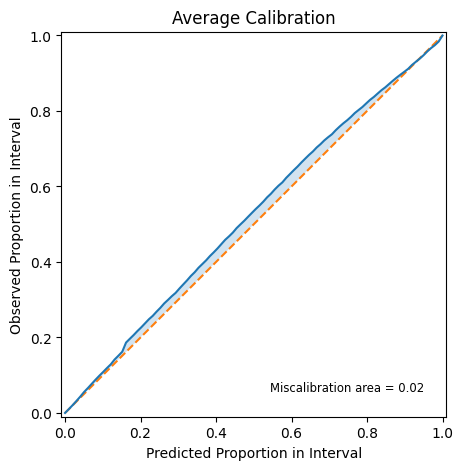

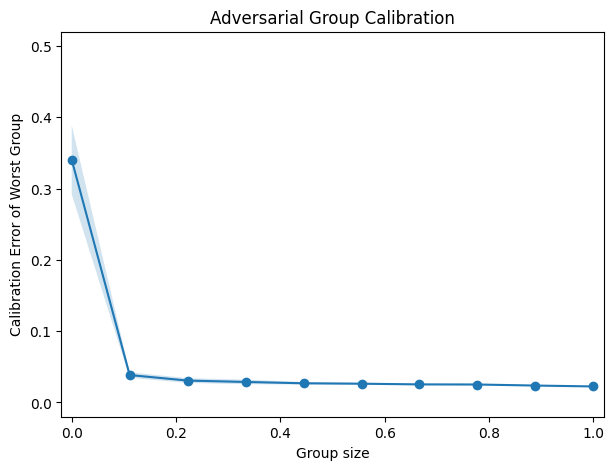

In [8]:
# Calculate the mean and standard deviation of the predictions on the test data
DE_mean = np.mean(outputs_mean, axis = 0).reshape(-1)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
DE_std = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic).reshape(-1)

# Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
pnn_metrics = uct.metrics.get_all_metrics( DE_mean, DE_std, y_test)
print(pnn_metrics)
print(pnn_metrics['accuracy']['rmse'])
# Calculate coverage for 95% confidence interval
coverage_95 = uct.metrics_calibration.get_proportion_in_interval(DE_mean, DE_std, y_test, quantile = 0.95 )
print(f"Coverage 95%: {coverage_95}")

# use own function to calculate coverage and MPIW
ev_intervals = metrices.evaluate_intervals(DE_mean, DE_std, y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(DE_mean, DE_std, y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(DE_mean, DE_std, y_test)

Epistemic Variance: 0.931632
Aleatoric Variance: 7.938569
first ten aleatoric variances: [[8.343437 ]
 [3.4125786]
 [6.75495  ]
 [2.6759624]
 [8.93439  ]
 [6.169595 ]
 [6.8771753]
 [4.4061484]
 [2.70387  ]
 [4.680951 ]] shape: (10403, 1)
first ten epistemic variances: [[0.8660189 ]
 [2.1532695 ]
 [0.32707435]
 [0.629849  ]
 [0.4755586 ]
 [0.88538516]
 [0.76996815]
 [0.44335088]
 [0.6214876 ]
 [1.2758006 ]] shape: (10403, 1)
 first ten total standard deviations: [[3.0347087]
 [2.359205 ]
 [2.6612074]
 [1.818189 ]
 [3.067564 ]
 [2.6561213]
 [2.7653468]
 [2.202158 ]
 [1.8235563]
 [2.4406457]] shape: (10403, 1)
Total Standard Deviation: 2.714539 
 y_test std: 7.556901931762695
torch.Size([10403, 1]) (10403, 1)
R² on Test Data: 0.854
Shape of de_lower_bound: (10403,), de_upper_bound: (10403,)
Number of true values within the confidence interval: 9982 out of 10403
Coverage: 95.95%


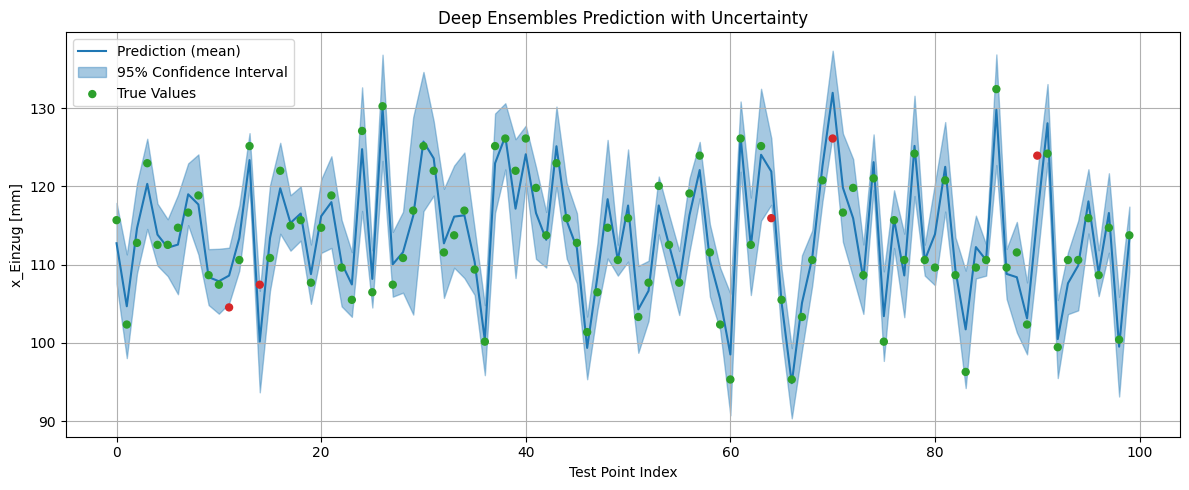

In [8]:
#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
mean_test_pred_heteroscedastic = np.mean(outputs_mean, axis = 0)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
total_std_heteroscedastic = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic)
print(f"first ten aleatoric variances: {aleatoric_var_heteroscedastic[:10]} shape: {aleatoric_var_heteroscedastic.shape}")
print(f"first ten epistemic variances: {epistemic_var_heteroscedastic[:10]} shape: {epistemic_var_heteroscedastic.shape}")
print(f" first ten total standard deviations: {total_std_heteroscedastic[:10]} shape: {total_std_heteroscedastic.shape}")
print(f"Total Standard Deviation: {total_std_heteroscedastic.mean():.6f} ")

print(f' y_test std: {y_test_tensor.std().item()}')
print(y_test_tensor.shape, mean_test_pred_heteroscedastic.shape)
# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu().squeeze(), mean_test_pred_heteroscedastic)


print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for Deep Ensembles mean and standard deviation
de_mean = mean_test_pred_heteroscedastic  # Predicted mean for each test point
de_std = total_std_heteroscedastic   # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
de_lower_bound = (de_mean - 2 * de_std).reshape(-1)  # Ensure it is a 1D array
de_upper_bound = (de_mean+ 2 * de_std).reshape(-1)  # Ensure it is a 1D array

print(f"Shape of de_lower_bound: {de_lower_bound.shape}, de_upper_bound: {de_upper_bound.shape}")

# calculate the coverage of the confidence interval
in_interval = (y_test >= de_lower_bound) & (y_test <= de_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= de_lower_bound[random_indices]) & (y_test[random_indices] <= de_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, de_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, de_lower_bound[random_indices], de_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("Deep Ensembles Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()